In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout
import math
from sklearn.metrics import mean_squared_error
from pathlib import Path
from tensorflow.keras.optimizers import SGD

In [2]:
data = Path('cleaned_data.csv')
#df = pd.read_csv(data, index_col='Unnamed: 0')
df = pd.read_csv(data)
df.head()

,Unnamed: 0,CANLORSGPNOSTSAM,inflation_common,inflation_trimmed_median,inflation_weighted_median,employment_rate,unemployment_rate,participation_rate,5_year_bond_benchmark,10_year_bond_benchmark,long_term_bond_benchmark,Bank of Canada Target Overnight Rate,Mortgage Rate
0,1990-01-01,102.220629,3.4,4.9,4.7,60.4,8.7,66.1,10.045000,9.965000,9.820000,12.04,12.01
1,1990-02-01,102.203404,3.3,4.7,4.5,60.6,8.4,66.2,10.538182,10.253636,9.999091,13.00,12.42
2,1990-03-01,102.130889,3.4,4.6,4.3,60.7,8.3,66.2,11.147692,10.761538,10.596154,13.13,12.92
3,1990-04-01,101.995714,3.5,4.5,4.2,61.1,7.9,66.4,12.175000,11.519286,11.275714,13.52,13.67
4,1990-05-01,101.800030,3.6,4.3,4.0,62.4,7.8,67.6,11.741538,11.125385,10.990000,13.80,14.21


In [3]:
df = df.rename({'Unnamed: 0': 'date', 'Mortgage Rate': 'mortgage_rate'}, axis=1)
df.head()

,date,CANLORSGPNOSTSAM,inflation_common,inflation_trimmed_median,inflation_weighted_median,employment_rate,unemployment_rate,participation_rate,5_year_bond_benchmark,10_year_bond_benchmark,long_term_bond_benchmark,Bank of Canada Target Overnight Rate,mortgage_rate
0,1990-01-01,102.220629,3.4,4.9,4.7,60.4,8.7,66.1,10.045000,9.965000,9.820000,12.04,12.01
1,1990-02-01,102.203404,3.3,4.7,4.5,60.6,8.4,66.2,10.538182,10.253636,9.999091,13.00,12.42
2,1990-03-01,102.130889,3.4,4.6,4.3,60.7,8.3,66.2,11.147692,10.761538,10.596154,13.13,12.92
3,1990-04-01,101.995714,3.5,4.5,4.2,61.1,7.9,66.4,12.175000,11.519286,11.275714,13.52,13.67
4,1990-05-01,101.800030,3.6,4.3,4.0,62.4,7.8,67.6,11.741538,11.125385,10.990000,13.80,14.21


In [4]:
df.set_index('date', inplace=True)
df.head()

,CANLORSGPNOSTSAM,inflation_common,inflation_trimmed_median,inflation_weighted_median,employment_rate,unemployment_rate,participation_rate,5_year_bond_benchmark,10_year_bond_benchmark,long_term_bond_benchmark,Bank of Canada Target Overnight Rate,mortgage_rate
date,,,,,,,,,,,,
1990-01-01,102.220629,3.4,4.9,4.7,60.4,8.7,66.1,10.045000,9.965000,9.820000,12.04,12.01
1990-02-01,102.203404,3.3,4.7,4.5,60.6,8.4,66.2,10.538182,10.253636,9.999091,13.00,12.42
1990-03-01,102.130889,3.4,4.6,4.3,60.7,8.3,66.2,11.147692,10.761538,10.596154,13.13,12.92
1990-04-01,101.995714,3.5,4.5,4.2,61.1,7.9,66.4,12.175000,11.519286,11.275714,13.52,13.67
1990-05-01,101.800030,3.6,4.3,4.0,62.4,7.8,67.6,11.741538,11.125385,10.990000,13.80,14.21


In [5]:
X = df.drop(['mortgage_rate'], axis=1)
y = df['mortgage_rate']

In [41]:
def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(df) - window - 1):
        features = df.iloc[i:(i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [42]:
window_size = 10

feature_column = 11
target_column = 11
X, y = window_data(df, window_size, feature_column, target_column)

In [43]:
split = int(0.7 * len(X))
X_train = X[: split]
X_test = X[split:]
y_train = y[: split]
y_test = y[split:]

In [44]:
from sklearn.preprocessing import MinMaxScaler
# Use the MinMaxScaler to scale data between 0 and 1.

scaler = MinMaxScaler()

scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

scaler.fit(y_train)

y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test) 

In [45]:
X_train.shape[0]

250

In [46]:
X_train.shape[1]

10

In [47]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

## Using GRU(Gated Recurrent Units)

In [48]:
# The GRU architecture
regressorGRU = Sequential()

In [49]:
# First GRU layer with Dropout regularisation
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))

In [50]:
# Second GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))

In [51]:
# Third GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))

In [52]:
# Fourth GRU layer
regressorGRU.add(GRU(units=50, activation='tanh'))
regressorGRU.add(Dropout(0.2))

In [53]:
# The output layer
regressorGRU.add(Dense(units=1))

In [54]:
# Compiling the RNN
regressorGRU.compile(optimizer=SGD(learning_rate=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')

In [55]:
# Fitting to the training set
regressorGRU.fit(X_train,y_train, epochs=50, batch_size=150)

Epoch 1/50
2/2 [==============================] - 6s 29ms/step - loss: 0.1523
Epoch 2/50
2/2 [==============================] - 0s 33ms/step - loss: 0.0817
Epoch 3/50
2/2 [==============================] - 0s 29ms/step - loss: 0.0524
Epoch 4/50
2/2 [==============================] - 0s 31ms/step - loss: 0.0752
Epoch 5/50
2/2 [==============================] - 0s 29ms/step - loss: 0.0902
Epoch 6/50
2/2 [==============================] - 0s 29ms/step - loss: 0.0669
Epoch 7/50
2/2 [==============================] - 0s 28ms/step - loss: 0.0419
Epoch 8/50
2/2 [==============================] - 0s 29ms/step - loss: 0.0483
Epoch 9/50
2/2 [==============================] - 0s 25ms/step - loss: 0.0579
Epoch 10/50
2/2 [==============================] - 0s 28ms/step - loss: 0.0532
Epoch 11/50
2/2 [==============================] - 0s 26ms/step - loss: 0.0404
Epoch 12/50
2/2 [==============================] - 0s 28ms/step - loss: 0.0351
Epoch 13/50
2/2 [==============================] - 0s 28ms/st

In [56]:
regressorGRU.evaluate(X_test, y_test, verbose=1)

4/4 [==============================] - 1s 6ms/step - loss: 6.0594e-04


0.0006059362203814089

In [57]:
predicted = regressorGRU.predict(X_test)

In [58]:
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [59]:
#mortgage = pd.DataFrame({
#    "Real": real_prices.ravel(),
#    "Predicted": predicted_prices.ravel()
#}, index = df.index[-len(real_prices): ]) 
#mortgage.head()

In [60]:
#mortgage.plot(title="Real Vs. Predicted")

In [61]:
#X_test = []
#for i in range(60,311):
#    X_test.append(inputs[i-60:i,0])
#X_test = np.array(X_test)
#X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
#GRU_predicted_stock_price = regressorGRU.predict(X_test)
#GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)

In [62]:
mortgage = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = df.index[-len(real_prices): ]) 
mortgage.tail()

,Real,Predicted
date,,
2021-04-01,3.26,3.586741
2021-05-01,3.25,3.534044
2021-06-01,3.25,3.489607
2021-07-01,3.26,3.455429
2021-08-01,3.20,3.429320


<AxesSubplot:title={'center':'Real Mortgage rate Vs. Predicted Mortgage rate'}, xlabel='date'>

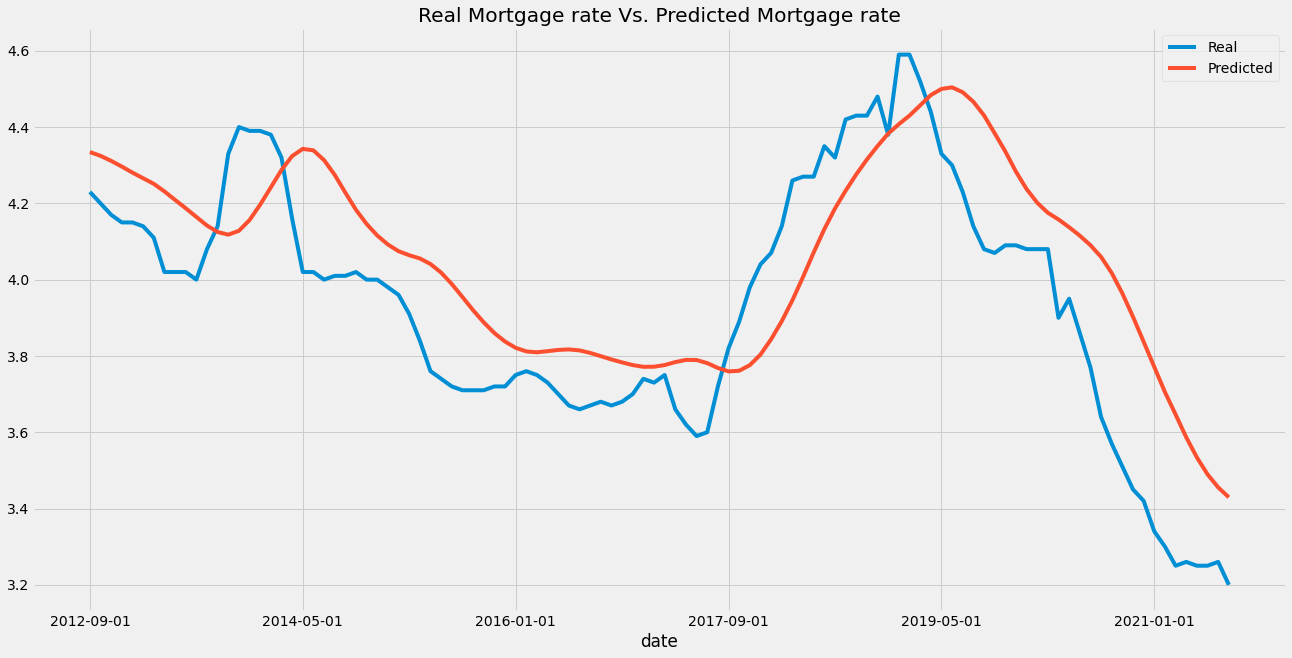

In [63]:
mortgage.plot(figsize=(20, 10), title="Real Mortgage rate Vs. Predicted Mortgage rate")

In [32]:
#def plot_multi_step(history, prediction1):
    
#    plt.figure(figsize=(15, 6))
    
#    range_history = len(history)
#    range_future = list(range(range_history, range_history +
#                        len(prediction1)))
#    plt.plot(np.arange(range_history), np.array(history), 
#             label='History')
#    plt.plot(range_future, np.array(prediction1),
#             label='Forecasted for GRU')
#    plt.plot(range_future, np.array(prediction2),
#             label='Forecasted for BiLSTM')
      
#    plt.legend(loc='upper right')
#    plt.xlabel('Time step (day)')
 #   plt.ylabel('Water demand (lit/day)')
        
#plot_multi_step(new_data, prediction_gru)

In [33]:
from keras.models import load_model

regressorGRU.save('GRU_model.h5')

In [34]:
model_gu = load_model('GRU_model.h5')

In [35]:
future_predictions = model_gu.predict(X, verbose=0)

In [36]:
future_df = pd.DataFrame(future_predictions)
future_index = pd.date_range(start='2021-09-01', periods=358, freq='MS')
future_index

DatetimeIndex(['2021-09-01', '2021-10-01', '2021-11-01', '2021-12-01',
               '2022-01-01', '2022-02-01', '2022-03-01', '2022-04-01',
               '2022-05-01', '2022-06-01',
               ...
               '2050-09-01', '2050-10-01', '2050-11-01', '2050-12-01',
               '2051-01-01', '2051-02-01', '2051-03-01', '2051-04-01',
               '2051-05-01', '2051-06-01'],
              dtype='datetime64[ns]', length=358, freq='MS')

In [37]:
future_df['date'] = future_index
future_df.set_index('date', inplace=True)

In [38]:
future_df_5 = future_df.loc[:'2026-08-01']

<AxesSubplot:title={'center':'Predicted'}, xlabel='date'>

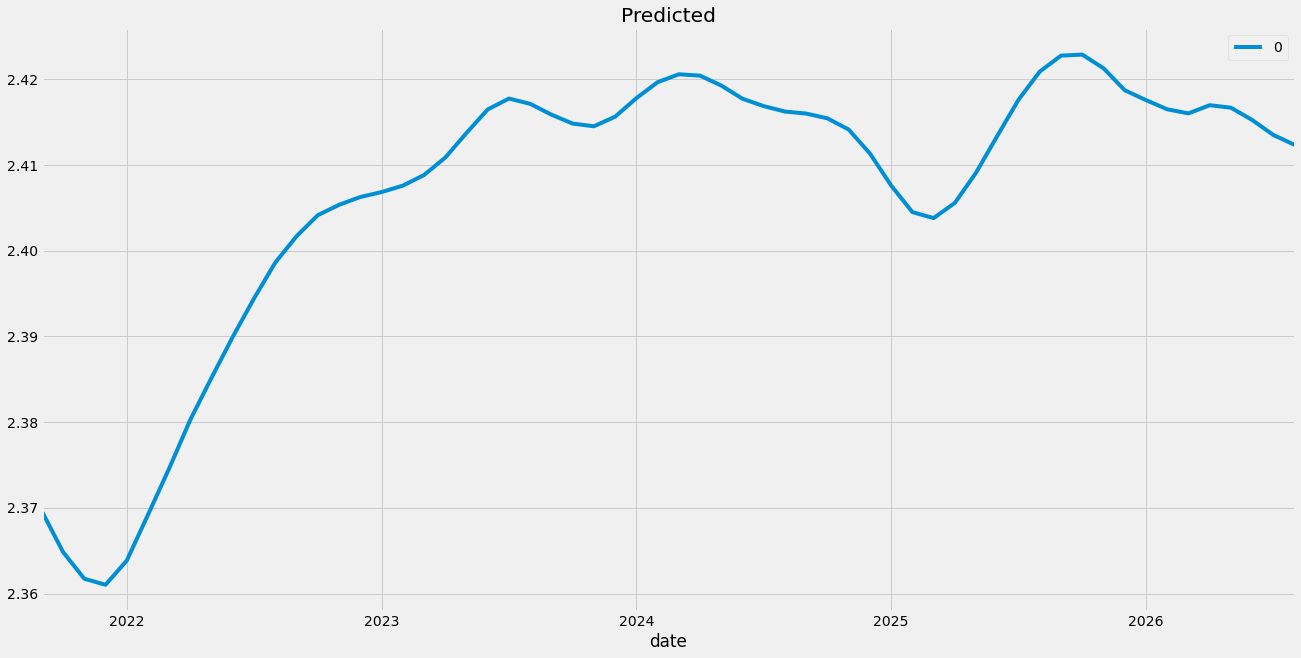

In [39]:
future_df_5.plot(figsize=(20, 10), title='Predicted')